<a href="https://colab.research.google.com/github/nqa112/times-series-forecasting/blob/main/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BASIC SETUP

In [ ]:
from pathlib import Path
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [ ]:
# Set random seed
SEED = 12
torch.manual_seed(SEED)
np.random.seed(SEED)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}.")

Using cpu.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

# Box
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['navy','goldenrod'])

# Grid and axis thickness, color
rcParams['axes.linewidth'] = 1
rcParams['axes.edgecolor'] = 'grey'
rcParams['axes.ymargin'] = 0
rcParams['axes.grid'] = True
rcParams['axes.grid.axis'] = 'y'
rcParams['axes.axisbelow'] = True
rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = "--"

# xticks, yticks
rcParams['ytick.major.width'] = 0
rcParams['ytick.major.size'] = 0
rcParams['ytick.color'] = 'dimgrey'
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.size'] = 3
rcParams['xtick.color'] = 'dimgrey'

# Line thickness
rcParams['lines.linewidth'] = 1.3

# Saving quality
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 500
rcParams['savefig.transparent'] = True

## LOAD DATA

In [ ]:
csv_path = Path("BVData.csv")
df = pd.read_csv(csv_path)

# Convert into a DateTime type
df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y-%m-%d %H:%M")
# Remove redundant features
df = df.drop(columns=["Date", "Time", "Month"])

In [ ]:
df.head()

,DateTime,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,QV
0,2020-01-01 00:00:00,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
1,2020-01-01 01:00:00,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
2,2020-01-01 02:00:00,0.6,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
3,2020-01-01 03:00:00,0.6,0.0,0.0,0.0,0.6,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
4,2020-01-01 04:00:00,0.4,0.0,0.0,0.0,0.8,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21888 entries, 0 to 21887
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  21888 non-null  datetime64[ns]
 1   1         21888 non-null  float64       
 2   2         21888 non-null  float64       
 3   3         21888 non-null  float64       
 4   4         21888 non-null  float64       
 5   5         21888 non-null  float64       
 6   6         21888 non-null  float64       
 7   7         21888 non-null  float64       
 8   8         21888 non-null  float64       
 9   9         21888 non-null  float64       
 10  10        21888 non-null  float64       
 11  11        21888 non-null  float64       
 12  12        21888 non-null  float64       
 13  13        21888 non-null  float64       
 14  14        21888 non-null  float64       
 15  15        21888 non-null  float64       
 16  16        21888 non-null  float64       
 17  17        21

## DATA PREPROCESSING

### Feature engineering

#### Date related features

In [ ]:
# Day in a month
df["Day_of_month"] = df.DateTime.apply(lambda x: x.day)
# Day in a week
df["Day_of_week"] = df.DateTime.apply(lambda x: x.dayofweek)
# 24-hour based
df["Hour"] = df.DateTime.apply(lambda x: x.hour)
# Week in a year
df["Week"] = df.DateTime.apply(lambda x: x.week)
# Month in a year
df["Month"] = df.DateTime.apply(lambda x: x.month)

In [ ]:
# Set "DateTime" column as row index
df = df.set_index("DateTime")

In [ ]:
# Move target to the last column
target_feature = "QV"
df.insert(len(df.columns)-1, target_feature, df.pop(target_feature))
df.head()

,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,Day_of_month,Day_of_week,Hour,Week,Month,QV
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,0.0,0.0,0.0,0.0,1,2,0,1,1,31.0
2020-01-01 01:00:00,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,2,1,1,1,31.0
2020-01-01 02:00:00,0.6,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.2,0.0,...,0.0,0.0,0.0,0.0,1,2,2,1,1,31.0
2020-01-01 03:00:00,0.6,0.0,0.0,0.0,0.6,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,2,3,1,1,31.0
2020-01-01 04:00:00,0.4,0.0,0.0,0.0,0.8,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,2,4,1,1,31.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21888 entries, 2020-01-01 00:00:00 to 2022-06-30 23:00:00
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1             21888 non-null  float64
 1   2             21888 non-null  float64
 2   3             21888 non-null  float64
 3   4             21888 non-null  float64
 4   5             21888 non-null  float64
 5   6             21888 non-null  float64
 6   7             21888 non-null  float64
 7   8             21888 non-null  float64
 8   9             21888 non-null  float64
 9   10            21888 non-null  float64
 10  11            21888 non-null  float64
 11  12            21888 non-null  float64
 12  13            21888 non-null  float64
 13  14            21888 non-null  float64
 14  15            21888 non-null  float64
 15  16            21888 non-null  float64
 16  17            21888 non-null  float64
 17  18            21888 non-null  floa

### Hyperparameters

In [ ]:
batch_size = 32
in_seq_len = 24 # How far to look back
out_seq_len = 12 # How far to look forward

enc_in_size = df.shape[1] # Number of input features + target feature
dec_in_size = 6 # Number of known future features + target feature
output_size = 1 # Number of target features
hidden_size = 64 # Dimensions in hidden layers
num_layers = 1 # Number of hidden layers
teaching_forcing_prob = 0.75 # Probability of teaching forcing

num_epochs = 100
learning_rate = 5e-3
es_patience = 15
lr_patience = 5

model_save_path = "checkpoint_seq2seq.pth"

## DATASET PIPELINE

#### Train - Val - Test split

In [ ]:
data = df.values
data.shape

(21888, 27)

In [ ]:
train_ratio, val_ratio = 0.7, 0.2
train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)

df_train = data[: train_size].copy()
df_val = data[train_size : train_size+val_size].copy()
df_test = data[train_size+val_size :].copy()

### Feature scaling
Use natural log transformation (with one plus element-wise to avoid inf. values)

In [ ]:
train_scaled = np.log1p(df_train)
val_scaled = np.log1p(df_val)
test_scaled = np.log1p(df_test)

### Create data sequences

In [ ]:
# split a multivariate sequence past, future samples (X and y)
def sequence_generator(arr, past_step=in_seq_len, future_step=out_seq_len, y_features=dec_in_size):
    # instantiate X and y
    X, y = [], []
    for i in range(len(arr)):
        # find the end of the input, output sequence
        input_end = i + past_step
        output_end = input_end + future_step
        # check if we are beyond the dataset
        if output_end > len(arr):
            break
        else:
            # gather input and output of the pattern
            seq_x, seq_y = arr[i : input_end], arr[input_end : output_end, -y_features:]
            X.append(seq_x), y.append(seq_y)

    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = sequence_generator(train_scaled)
X_val, y_val = sequence_generator(val_scaled)
X_test, y_test = sequence_generator(test_scaled)

print("Training Shape:", X_train.shape, y_train.shape)
print("Validation Shape:", X_val.shape, y_val.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (15286, 24, 27) (15286, 12, 6)
Validation Shape: (4342, 24, 27) (4342, 12, 6)
Testing Shape: (2155, 24, 27) (2155, 12, 6)


### Create Dataset Iterator

#### Define custom dataset

In [ ]:
class TimeSeriesDataset(Dataset):

    def __init__(self, X, y):
        # convert into PyTorch tensors and remember them
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)


    def __len__(self):
        # this should return the size of the dataset
        return len(self.X)


    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        return features, target

In [ ]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

#### Generate from PyTorch's `DataLoader` class

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 24, 27])
Target shape: torch.Size([32, 12, 6])


## MODEL AND LEARNING ALGORITHM

### Model architecture

#### Encoder

In [ ]:
class Encoder(nn.Module):

    def __init__(self, encoder_input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()

        # Number of input features
        self.encoder_input_size = encoder_input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=self.encoder_input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

    def forward(self, encoder_inputs):
        """
        encoder_inputs: Shape (batch_size x look_back x input_size)
          [(X_t-N, feature_t-N), ..., (X_t-1, feature_t-1), (X_t, feature_t)]
        """
        # Feed in the whole sequence
        # PyTorch will handle the rollout
        _, hidden = self.lstm(encoder_inputs)
        # Return final hidden state (context vector)
        return hidden

#### Decoder

In [ ]:
class Decoder(nn.Module):

    def __init__(self, decoder_input_size, target_size, hidden_size, num_layers):
        super(Decoder, self).__init__()

        # Predection size
        # i.e univariate forecasting has output size of 1
        self.target_size = target_size
        self.decoder_input_size = decoder_input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=self.decoder_input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        # Transform the latent representation
        # back to a single prediction
        self.fc = nn.Linear(self.hidden_size, self.target_size)


    def forward(self, input_init, encoder_hidden, targets, teaching_forcing_prob):
        """
        input_init:  Shape (batch_size x 1 x input_size)
          (X_t, feature_t)
        encoder_hidden: Shape (num_layers*num_directions x batch_size x hidden_size)
          Context vector from the encoder
        targets: Shape (batch_size x pred_len x features_size)
          Our targets [(X_t+1, feature_t+1), (X_t+2, feature_t+2), .. (X_t+N, feature_t+N)]
          Note: features are used as future covariates for prediction only
        teaching_forcing_prob: float
          The chance of using truth value instead of predicted output for next time step
        """
        # Forecasting steps
        decoder_seq_len = targets.shape[1]
        # Store decoder outputs
        outputs = torch.tensor([])
        # Input at time step t
        input_t = input_init[:, -1, -self.decoder_input_size:].unsqueeze(1)

        # Rollout the sequence
        for t in range(decoder_seq_len):
            # Change input dim from (B, C) into (B, 1, C)
            out, hidden = self.lstm(input_t, encoder_hidden)
            # Shape (batch size, 1, target size)
            out = self.fc(out)
            outputs = torch.cat((outputs, out), 1)
            # Setup for next time step
            # Use actual output
            if random.random() < teaching_forcing_prob:
                input_t = targets[:, t, :].unsqueeze(1)
            # Use predicted output with known future features (DateTime...)
            else:
                future_features = targets[:, t, -self.decoder_input_size:-1].unsqueeze(1)
                input_t = torch.concat((future_features, out), 2)

        # Shape (batch size, pred step, target features)
        return outputs

#### Seq2Seq Model

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, enc_in_size, dec_in_size, output_size, hidden_size, num_layers):
        super(Seq2Seq, self).__init__()

        self.encoder = Encoder(enc_in_size, hidden_size, num_layers)
        self.decoder = Decoder(dec_in_size, output_size, hidden_size, num_layers)


    def forward(self, encoder_inputs, targets, teaching_forcing_prob):
        encoder_hidden = self.encoder(encoder_inputs)
        # Feed last time step value from encoder
        outputs = self.decoder(encoder_inputs, encoder_hidden, targets, teaching_forcing_prob)
        return outputs

In [ ]:
model = Seq2Seq(enc_in_size, dec_in_size, output_size, hidden_size, num_layers).to(device)
total_params = sum(p.numel() for p in model.parameters())
learn_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f"\nTotal parameters: {total_params}")
print(f"Learnable parameters: {learn_params}")

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(27, 64, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(6, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total parameters: 42305
Learnable parameters: 42305


### Loss and Optimizer

In [ ]:
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

### Callbacks

In [ ]:
# Early Stopping
# Stop training if validation loss does not improve
class EarlyStopping:

    def __init__(self, patience, model_save_path, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.model_save_path = model_save_path
        self.counter = 0
        self.min_validation_loss = np.inf
        self.best_epoch = 0
        self.early_stop = False


    def __call__(self, epoch, model, validation_loss):
        delta_loss = self.min_validation_loss - validation_loss
        # Check if val loss is smaller than min loss
        if delta_loss > self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Save best model
            self.best_epoch = epoch
            torch.save(model.state_dict(), self.model_save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early Stopping.")
                print(f"Save best model at epoch {self.best_epoch}")
                self.early_stop = True

In [ ]:
# ReduceLROnPlateau
# Reduce learning rate when validation loss stops improving
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.3, patience=lr_patience, verbose=True)

## TRAINING

### Define training loop

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        output = model(X, y, teaching_forcing_prob)
        loss = loss_function(output, y[:, :, -1].unsqueeze(2))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_avg_loss = total_loss / num_batches

    return train_avg_loss


def val_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            output = model(X, y, 0)
            total_loss += loss_function(output, y[:, :, -1].unsqueeze(2)).item()

    val_avg_loss = total_loss / num_batches

    return val_avg_loss

In [ ]:
# Log losses for plotting
all_losses = []

# Initialize Early Stopping object
early_stopper = EarlyStopping(patience=es_patience, model_save_path=model_save_path)
for epoch in range(num_epochs):
    train_loss = train_model(train_loader, model, loss_func, opt)
    val_loss = val_model(val_loader, model, loss_func)
    all_losses.append([train_loss, val_loss])

    # Display
    print(f"\nEpoch [{epoch}/{num_epochs-1}]\t\tTrain loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")

    # EarlyStopping
    early_stopper(epoch, model, val_loss)
    if early_stopper.early_stop:
        break
    # Adjust learning rate
    lr_scheduler.step(val_loss)


Epoch [0/99]		Train loss: 0.314320 - Val loss: 0.031768

Epoch [1/99]		Train loss: 0.016886 - Val loss: 0.027576

Epoch [2/99]		Train loss: 0.011701 - Val loss: 0.198875

Epoch [3/99]		Train loss: 0.010590 - Val loss: 0.027217

Epoch [4/99]		Train loss: 0.010151 - Val loss: 0.080588

Epoch [5/99]		Train loss: 0.008712 - Val loss: 0.090484

Epoch [6/99]		Train loss: 0.010749 - Val loss: 0.027150

Epoch [7/99]		Train loss: 0.009537 - Val loss: 0.036120

Epoch [8/99]		Train loss: 0.006003 - Val loss: 0.029662

Epoch [9/99]		Train loss: 0.019718 - Val loss: 0.045981

Epoch [10/99]		Train loss: 0.007225 - Val loss: 0.027747

Epoch [11/99]		Train loss: 0.007989 - Val loss: 0.044048

Epoch [12/99]		Train loss: 0.008500 - Val loss: 0.026424

Epoch [13/99]		Train loss: 0.005760 - Val loss: 0.065086

Epoch [14/99]		Train loss: 0.009026 - Val loss: 0.057292

Epoch [15/99]		Train loss: 0.007861 - Val loss: 0.121246

Epoch [16/99]		Train loss: 0.006564 - Val loss: 0.029601

Epoch [17/99]		Train lo

### Plot history

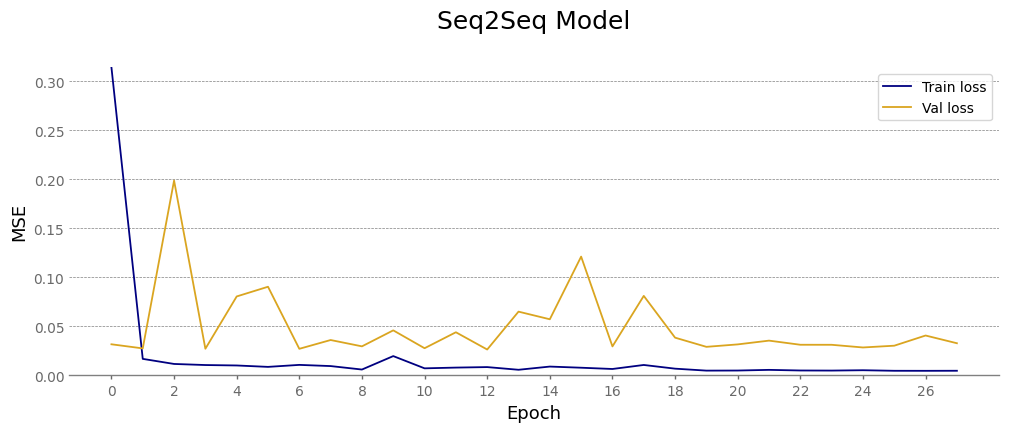

In [ ]:
plt.figure(figsize=(12, 4))
plt.title("Seq2Seq Model", size=18, y=1.1)
plt.plot(all_losses, label=["Train loss", "Val loss"])
plt.xlabel("Epoch", fontsize=13)
plt.xticks(np.arange(0, len(all_losses), 2))
plt.ylabel("MSE", fontsize=13)
plt.ylim(bottom=0)
plt.legend(loc="upper right", fontsize=10)
plt.show()

## EVALUATION

### Load best checkpoint

In [ ]:
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

### Predict

In [ ]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            y_pred = model(X.to(device), y.to(device), 0)
            output = torch.cat((output, y_pred.to(device)), 0)

    return output

In [ ]:
y_pred = predict(test_loader, model).numpy()

# Inverse the transformation
y_pred_inv = np.expm1(y_pred)
y_test_inv = np.expm1(y_test)

### Metrics


In [ ]:
# Hours ahead to predict
forecast_length = 12

In [ ]:
truth = y_test_inv[:, forecast_length-1, -1].ravel()
forecast = y_pred_inv[:, forecast_length-1].ravel()

diff = np.subtract(truth, forecast)
# MAPE
mape = np.mean(np.abs(diff / truth))
# MSE
mse = np.mean(np.square(diff))
# RMSE
rmse = np.sqrt(mse)
# NSE
num = np.sum(np.square(diff))
den = np.sum(np.square(np.subtract(truth, truth.mean())))
nse = 1 - (num / den)

print(f"{forecast_length}-hour forecast MAPE : {mape:.4f}")
print(f"{forecast_length}-hour forecast MSE : {mse:.4f}")
print(f"{forecast_length}-hour forecast RMSE: {rmse:.4f}")
print(f"{forecast_length}-hour forecast NSE: {nse:.4f}")

12-hour forecast MAPE : 0.1807
12-hour forecast MSE : 657.1596
12-hour forecast RMSE: 25.6351
12-hour forecast NSE: 0.5560


### Visualize forecasts

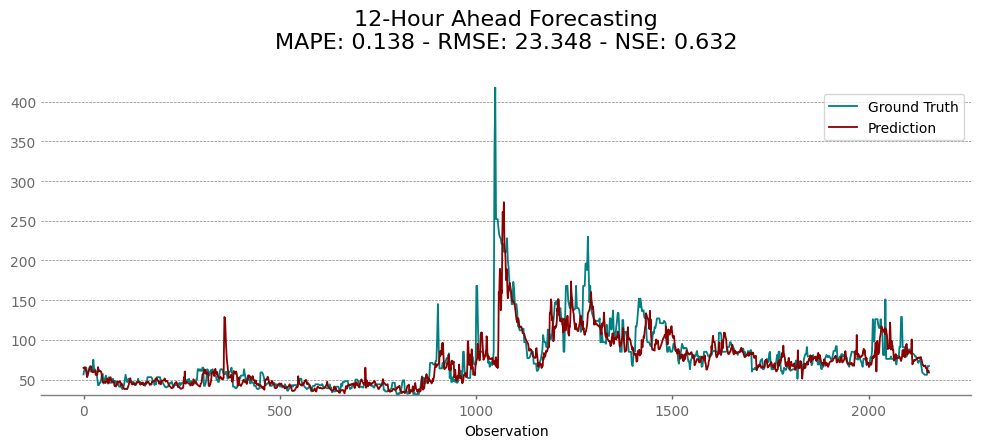

In [ ]:
plt.figure(figsize=(12, 4))
plt.title(f"{forecast_length}-Hour Ahead Forecasting\nMAPE: {mape:.3f} - RMSE: {rmse:.3f} - NSE: {nse:.3f}", size=16, y=1.1)
plt.plot(truth, label="Ground Truth", color="teal")
plt.plot(forecast, label="Prediction", color="darkred")
plt.xlabel("Observation")
plt.legend(fontsize=10)
plt.show()